In [15]:
import pandas as pd

# CSV-Datei laden (Pfad anpassen)
df = pd.read_csv('/workspace/project/catatonia_VAE-main_bq/data/proc_extracted_xml_data/Proc_neuromorphometrics_Vgm_Vwm_Vcsf_uiui.csv')

# Shape ausgeben
print(f"Shape der Datei: {df.shape}")  # Gibt (Zeilen, Spalten) aus

Shape der Datei: (136, 8647)


1. Concatenation Method:
Keine Standardisierung angewendet - Daten bereits vorverarbeitet.


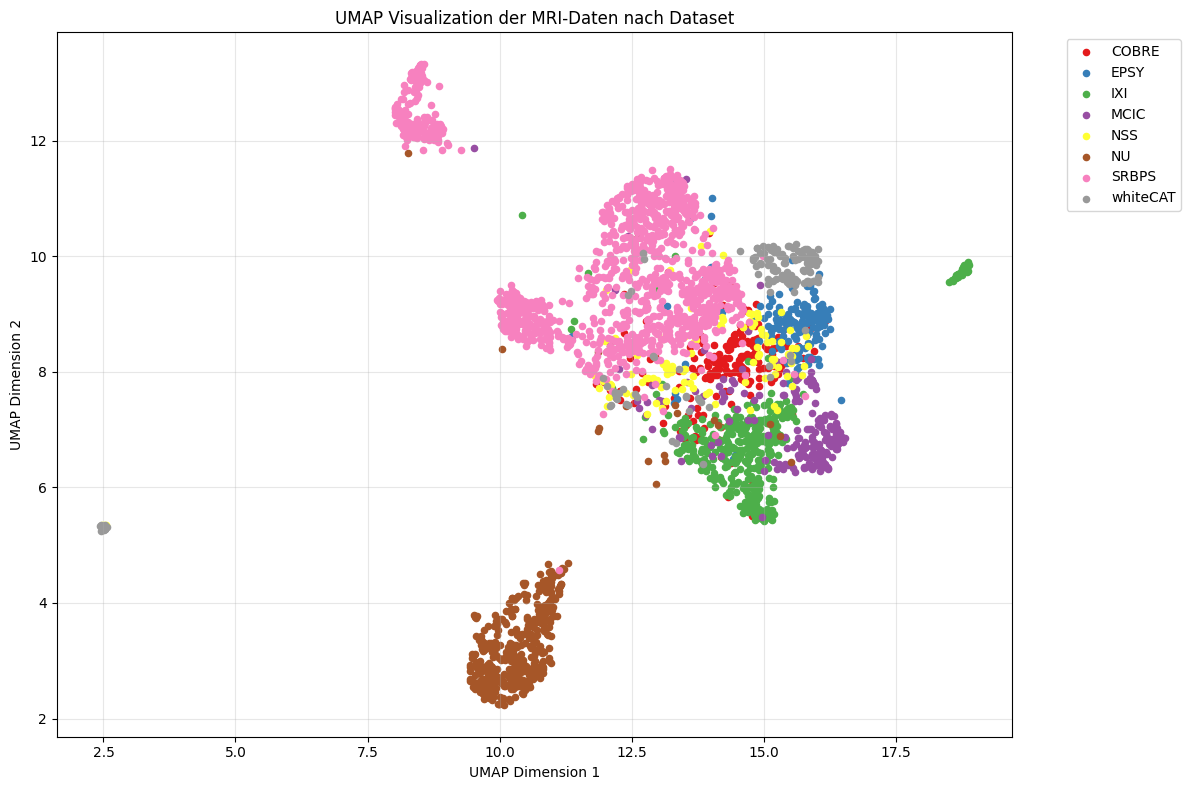


Final data shape: (2882, 410)
Number of patients: 2882
Datasets found: ['NU' 'EPSY' 'whiteCAT' 'MCIC' 'SRBPS' 'NSS' 'COBRE' 'IXI']


In [23]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def prepare_data_for_umap(csv_path, metadata_path, combination_method='concatenate'):
    """
    Bereitet MRI-Daten für UMAP vor, indem Volume-Types pro Patient kombiniert werden.
    
    Parameters:
    - csv_path: Pfad zur CSV mit MRI-Daten
    - metadata_path: Pfad zur Metadata mit Dataset-Information
    - combination_method: 'concatenate', 'mean', 'pca', oder 'weighted_mean'
    """
    
    # Lade die Daten
    mri_data = pd.read_csv(csv_path, index_col=0)
    metadata = pd.read_csv(metadata_path)
    
    # Extrahiere Patient IDs aus den Spaltennamen (Format: PatientID_VolumeType)
    patient_ids = []
    volume_types = []
    
    for col in mri_data.columns:
        parts = col.rsplit('_', 1)  # Split vom Ende, um VolumeType zu trennen
        if len(parts) == 2:
            patient_id, vol_type = parts
            patient_ids.append(patient_id)
            volume_types.append(vol_type)
    
    # Erstelle DataFrame mit Patient-Volume Mapping
    col_info = pd.DataFrame({
        'column': mri_data.columns,
        'patient_id': patient_ids,
        'volume_type': volume_types
    })
    
    # Gruppiere nach Patient
    unique_patients = col_info['patient_id'].unique()
    combined_data = []
    final_patient_ids = []
    
    for patient in unique_patients:
        patient_cols = col_info[col_info['patient_id'] == patient]['column'].tolist()
        patient_data = mri_data[patient_cols]
        
        if combination_method == 'concatenate':
            # Einfach alle Volume-Types hintereinander hängen
            combined_row = patient_data.values.flatten()
    
        
        combined_data.append(combined_row)
        final_patient_ids.append(patient)
    
    # Erstelle finalen DataFrame
    combined_df = pd.DataFrame(combined_data, index=final_patient_ids)
    
    # Merge mit Metadata
    metadata_clean = metadata.copy()
    # Entferne Dateiendungen aus Filename falls vorhanden
    metadata_clean['patient_id'] = metadata_clean['Filename'].str.replace(r'\.[^.]+$', '', regex=True)
    
    # Merge auf Patient ID
    final_data = combined_df.merge(
        metadata_clean[['patient_id', 'Dataset']], 
        left_index=True, 
        right_on='patient_id', 
        how='inner'
    )
    
    return final_data

def create_umap_visualization(final_data, n_neighbors=15, min_dist=0.1, random_state=42, apply_scaling=False):
    """
    Erstellt UMAP Visualization der kombinierten Daten.
    """
    
    # Separiere Features und Labels
    feature_cols = [col for col in final_data.columns if col not in ['patient_id', 'Dataset']]
    X = final_data[feature_cols].values
    datasets = final_data['Dataset'].values
    
    # Standardisierung nur wenn gewünscht
    if apply_scaling:
        scaler = StandardScaler()
        X_processed = scaler.fit_transform(X)
        print("Daten wurden standardisiert.")
    else:
        X_processed = X
        print("Keine Standardisierung angewendet - Daten bereits vorverarbeitet.")
    
    # UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state,
        n_components=2
    )
    
    embedding = reducer.fit_transform(X_processed)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    unique_datasets = np.unique(datasets)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_datasets)))
    
    for i, dataset in enumerate(unique_datasets):
        mask = datasets == dataset
        plt.scatter(
            embedding[mask, 0], 
            embedding[mask, 1], 
            c=[colors[i]], 
            label=dataset, 
            alpha=1.0,
            s=20
        )
    
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('UMAP Visualization der MRI-Daten nach Dataset')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embedding, final_data


# Beispiel-Verwendung:
if __name__ == "__main__":
    # Pfade anpassen
    csv_path = "/workspace/project/catatonia_VAE-main_bq/data/proc_extracted_xml_data/Proc_neuromorphometrics_Vgm_Vwm_Vcsf_uiui.csv"
    metadata_path = "/workspace/project/catatonia_VAE-main_bq/metadata_20250110/full_data_with_codiagnosis_and_scores.csv"
    
    # Verschiedene Kombinationsmethoden testen:
    
    print("1. Concatenation Method:")
    data_concat = prepare_data_for_umap(csv_path, metadata_path, 'concatenate')
    embedding_concat, final_data_concat = create_umap_visualization(data_concat)
    
    print(f"\nFinal data shape: {final_data_concat.shape}")
    print(f"Number of patients: {len(final_data_concat)}")
    print(f"Datasets found: {final_data_concat['Dataset'].unique()}")